<font color = 'blue'>
Content: 

1. [Load Python Pakages](#1)
2. [First look to data](#2)
3. [Data Cleaning (Missing value removal)](#3)
4. [Descriptive statistics](#4)   
5. [Exploratory Data Analysis](#5)   
6. [Preprocessing](#6)
7. [Splitting data to train and test sets (Perform adversarial validation)](#7)
8. [Modeling and hyperparameter tuning](#8)
9. [Step 1: Train a base model with all features (XGBoost)](#9)
10. [Step 2: Feature Selection Based on Model's Importance Scores](#10)
11. [Step 3: Hyperparameter tunning with selected features](#11)  
12. [Explainable ML with SHAP](#12) 

<a id = "1"></a><br>
# Load Python Pakages


In [ ]:
#basics
import numpy as np
import pandas as pd 
import seaborn as sns
import matplotlib.pyplot as plt
import missingno as msno
import warnings
warnings.filterwarnings("ignore")

#preprocessing
from sklearn.preprocessing import StandardScaler
from sklearn.impute import SimpleImputer


#feature selection
from sklearn.feature_selection import mutual_info_classif
from sklearn.feature_selection import SelectFromModel

#transformers and pipeline
from sklearn.pipeline import Pipeline
from sklearn import set_config


#algorithms
from xgboost import XGBClassifier
#from lightgbm import LGBMClassifier
from sklearn.naive_bayes import GaussianNB


#model evaluation
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import RepeatedStratifiedKFold
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, roc_auc_score,  f1_score, recall_score, precision_score
from sklearn.metrics import make_scorer


# Optuna and visualization tools
import optuna
from optuna.samplers import TPESampler

# Dealing with imbalanced target
from imblearn.over_sampling import SMOTE
from imblearn.pipeline import Pipeline as imbpipeline

random_state = 42


ModuleNotFoundError: No module named 'lightgbm'

<a id = "2"></a><br>
#  First look to data

In [2]:
# Read the data
train_df = pd.read_csv("/kaggle/input/alzheimers-disease-dataset/alzheimers_disease_data.csv", index_col=[0])

train_df.index.names = ['id']
train_df = train_df.drop(['DoctorInCharge'], axis=1) #drop unnecessary column

# reserved 
pipe_data = train_df.copy()
train_df.head()

,Age,Gender,Ethnicity,EducationLevel,BMI,Smoking,AlcoholConsumption,PhysicalActivity,DietQuality,SleepQuality,...,FunctionalAssessment,MemoryComplaints,BehavioralProblems,ADL,Confusion,Disorientation,PersonalityChanges,DifficultyCompletingTasks,Forgetfulness,Diagnosis
id,,,,,,,,,,,,,,,,,,,,,
4751,73,0,0,2,22.927749,0,13.297218,6.327112,1.347214,9.025679,...,6.518877,0,0,1.725883,0,0,0,1,0,0
4752,89,0,0,0,26.827681,0,4.542524,7.619885,0.518767,7.151293,...,7.118696,0,0,2.592424,0,0,0,0,1,0
4753,73,0,3,1,17.795882,0,19.555085,7.844988,1.826335,9.673574,...,5.895077,0,0,7.119548,0,1,0,1,0,0
4754,74,1,0,1,33.800817,1,12.209266,8.428001,7.435604,8.392554,...,8.965106,0,1,6.481226,0,0,0,0,0,0
4755,89,0,0,0,20.716974,0,18.454356,6.310461,0.795498,5.597238,...,6.045039,0,0,0.014691,0,0,1,1,0,0


In [3]:
train_df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 2149 entries, 4751 to 6899
Data columns (total 33 columns):
 #   Column                     Non-Null Count  Dtype  
---  ------                     --------------  -----  
 0   Age                        2149 non-null   int64  
 1   Gender                     2149 non-null   int64  
 2   Ethnicity                  2149 non-null   int64  
 3   EducationLevel             2149 non-null   int64  
 4   BMI                        2149 non-null   float64
 5   Smoking                    2149 non-null   int64  
 6   AlcoholConsumption         2149 non-null   float64
 7   PhysicalActivity           2149 non-null   float64
 8   DietQuality                2149 non-null   float64
 9   SleepQuality               2149 non-null   float64
 10  FamilyHistoryAlzheimers    2149 non-null   int64  
 11  CardiovascularDisease      2149 non-null   int64  
 12  Diabetes                   2149 non-null   int64  
 13  Depression                 2149 non-null   int64  

<a id = "3"></a><br>
## Data Cleaning (Missing value handling)

Lets check and visualize missing values.

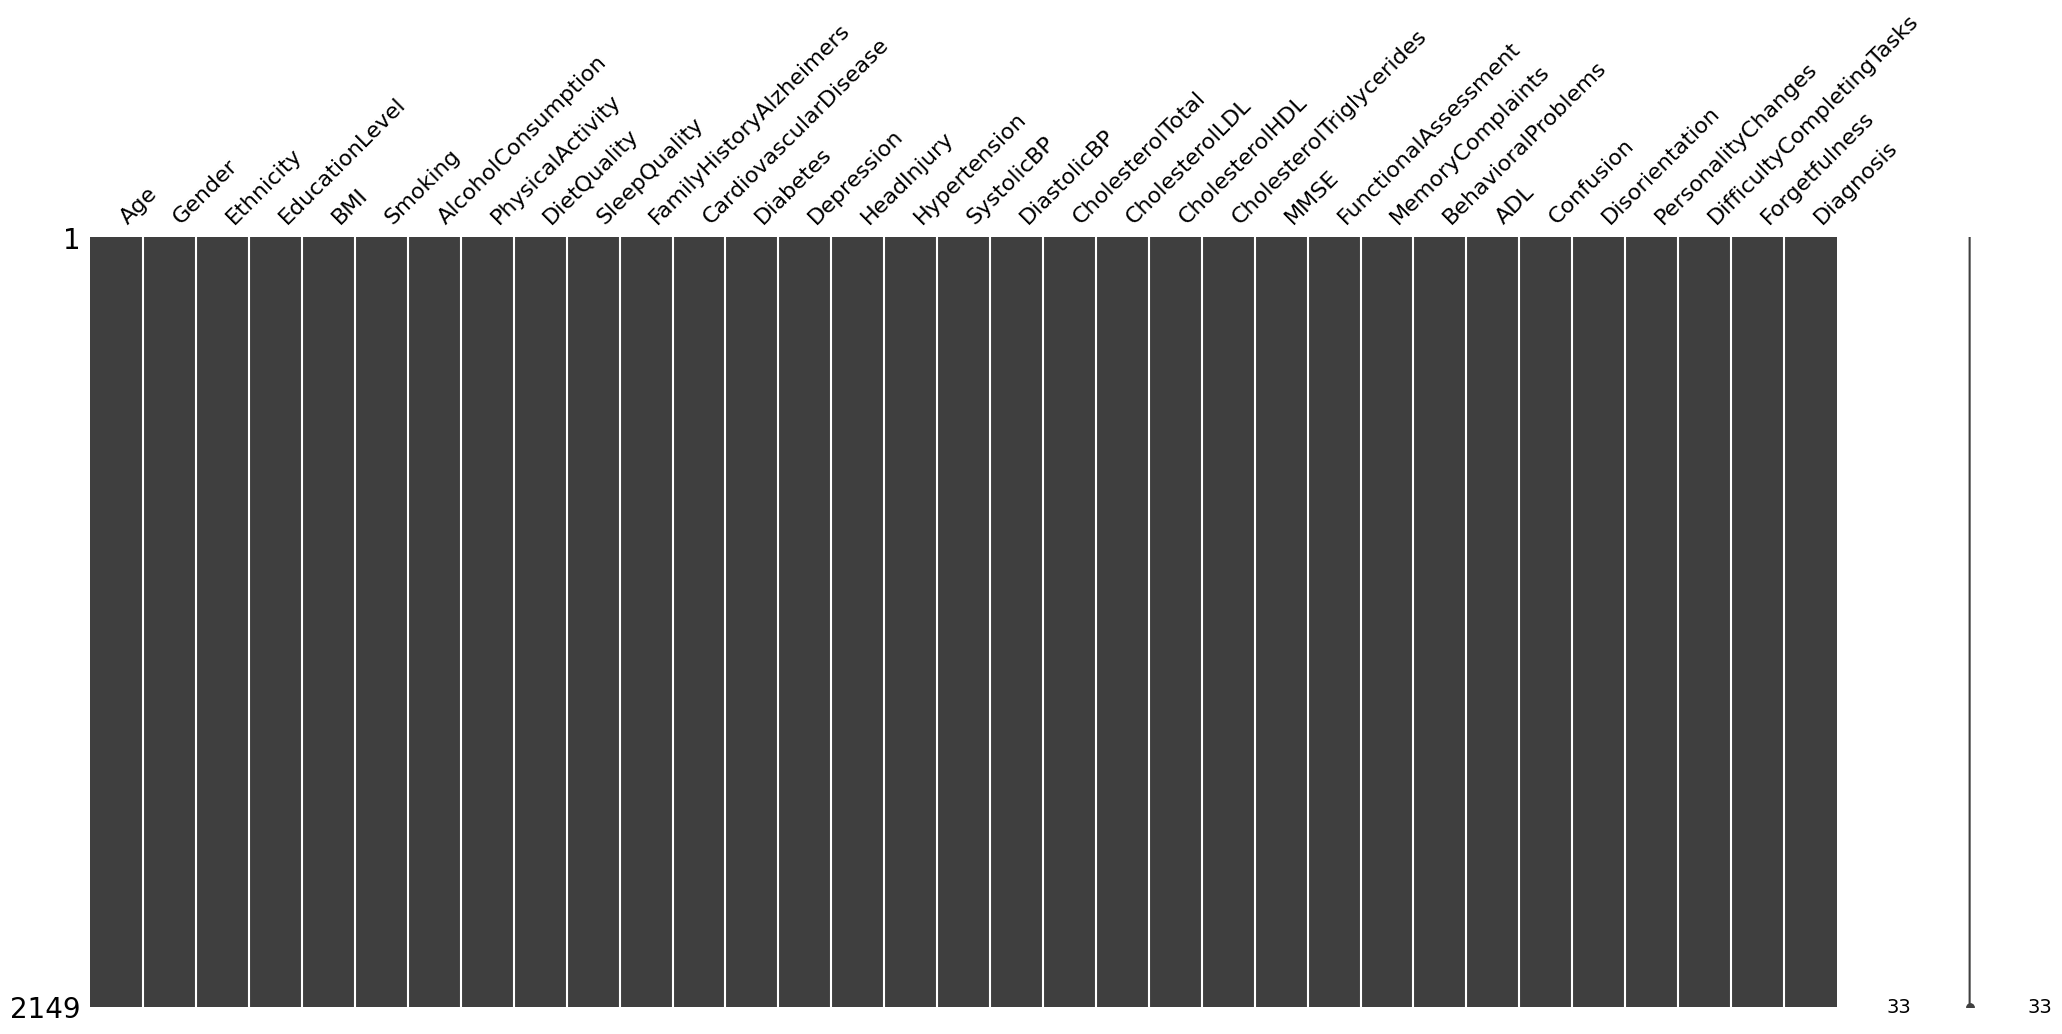

In [4]:
msno.matrix(train_df)
plt.show()

<a id = "4"></a><br>
## Descriptive statistics

Let's report basic descriptive statistics for data.

In [5]:
#descriptive statistics
train_df.describe().T

,count,mean,std,min,25%,50%,75%,max
Age,2149.0,74.908795,8.990221,60.000000,67.000000,75.000000,83.000000,90.000000
Gender,2149.0,0.506282,0.500077,0.000000,0.000000,1.000000,1.000000,1.000000
Ethnicity,2149.0,0.697534,0.996128,0.000000,0.000000,0.000000,1.000000,3.000000
EducationLevel,2149.0,1.286645,0.904527,0.000000,1.000000,1.000000,2.000000,3.000000
BMI,2149.0,27.655697,7.217438,15.008851,21.611408,27.823924,33.869778,39.992767
Smoking,2149.0,0.288506,0.453173,0.000000,0.000000,0.000000,1.000000,1.000000
AlcoholConsumption,2149.0,10.039442,5.757910,0.002003,5.139810,9.934412,15.157931,19.989293
PhysicalActivity,2149.0,4.920202,2.857191,0.003616,2.570626,4.766424,7.427899,9.987429
DietQuality,2149.0,4.993138,2.909055,0.009385,2.458455,5.076087,7.558625,9.998346
SleepQuality,2149.0,7.051081,1.763573,4.002629,5.482997,7.115646,8.562521,9.999840


Let's also observe target variable

In [6]:
train_df['Diagnosis'].value_counts()

Diagnosis
0    1389
1     760
Name: count, dtype: int64

We have 760 samples belonging class 1 and 1389 samples class 0

Let's make a visualization for class distribution.

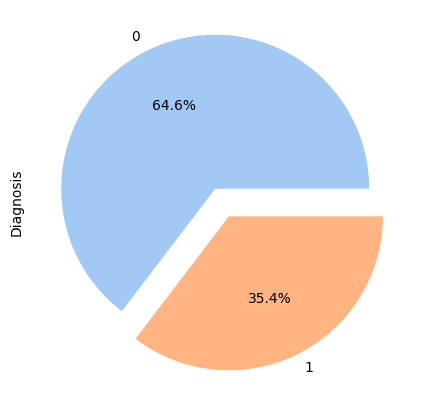

In [7]:
#Target Distribution plot
plt.figure(figsize=(5,5))
palette_color = sns.color_palette('pastel')
explode = [0.1, 0.1]
train_df.groupby('Diagnosis')['Diagnosis'].count().plot.pie(colors=palette_color,explode=explode, autopct="%1.1f%%");

Target variable distribution is not severely imbalanced. During the modeling phase, I tried the Synthetic Minority Over-sampling Technique (SMOTE), but it did not improve my CV score, so I abandoned it.

However, due to the imbalanced nature of the data, the F1 score is used as an optimization metric during modeling.

<a id = "5"></a><br>
# Exploratory Data Analysis

On this part we will explore relationship beetween target and features. 
This part includes:

* Some visualization 
* Reporting mutual information scores for features with respect to target
* And a correlation matrix between features

In [8]:
train_df.nunique().sort_values()

Diagnosis                       2
Hypertension                    2
HeadInjury                      2
Depression                      2
Diabetes                        2
CardiovascularDisease           2
FamilyHistoryAlzheimers         2
BehavioralProblems              2
Confusion                       2
Disorientation                  2
PersonalityChanges              2
Smoking                         2
DifficultyCompletingTasks       2
Gender                          2
Forgetfulness                   2
MemoryComplaints                2
EducationLevel                  4
Ethnicity                       4
Age                            31
DiastolicBP                    60
SystolicBP                     90
CholesterolLDL               2149
CholesterolHDL               2149
CholesterolTriglycerides     2149
MMSE                         2149
FunctionalAssessment         2149
SleepQuality                 2149
ADL                          2149
DietQuality                  2149
PhysicalActivi

In [9]:
# Store continuous and discrete features to different lists for visualization purposes

feature_list = [feature for feature in train_df.columns if not feature  == "Diagnosis"]

discrete_features =  [feature for feature in train_df.columns if train_df[feature].nunique() < 5 and feature != 'Diagnosis']

continuous_features = list(set(feature_list) - set(discrete_features))

assert feature_list.sort() == (discrete_features + continuous_features).sort()


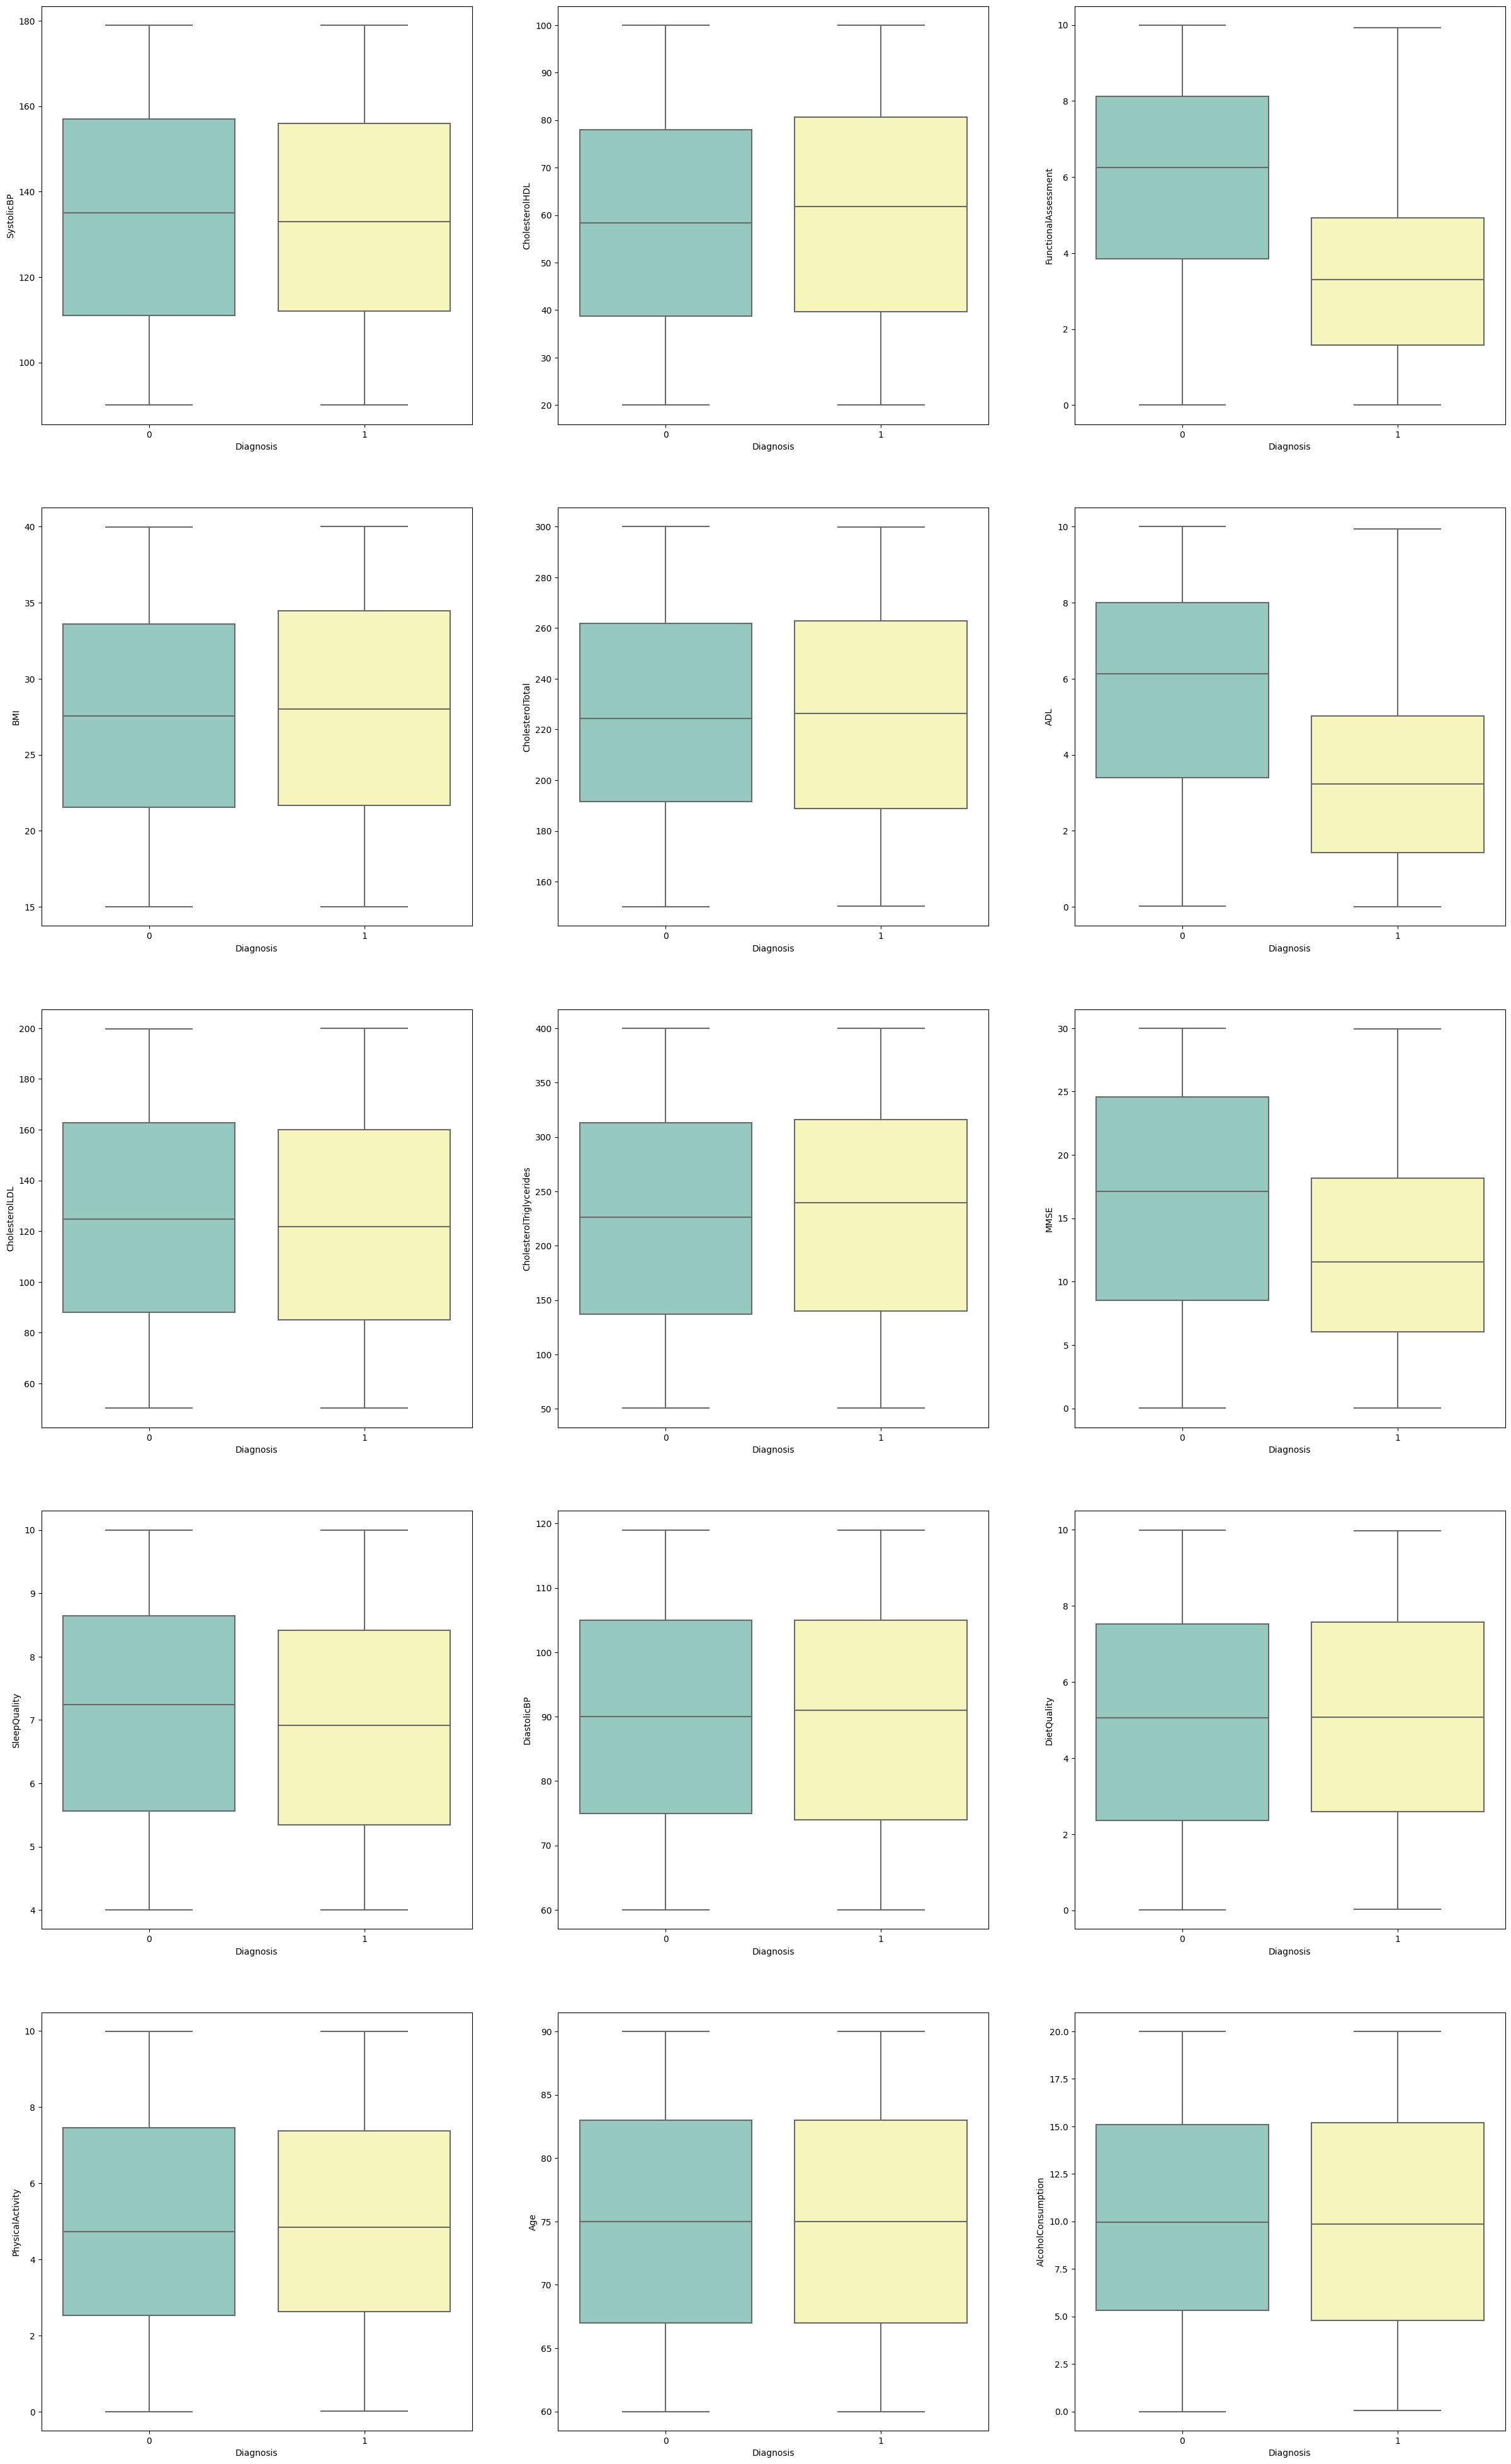

In [10]:
#Box-plots
fig, ax = plt.subplots(5, 3, figsize=(30, 50))
for var, subplot in zip(continuous_features, ax.flatten()):
    sns.boxplot(x='Diagnosis', y=var, data=train_df, ax=subplot, palette='Set3')

MMSE, FunctionalAssessment and ADL seem as important continuous features. 

Let's also check discrete ones

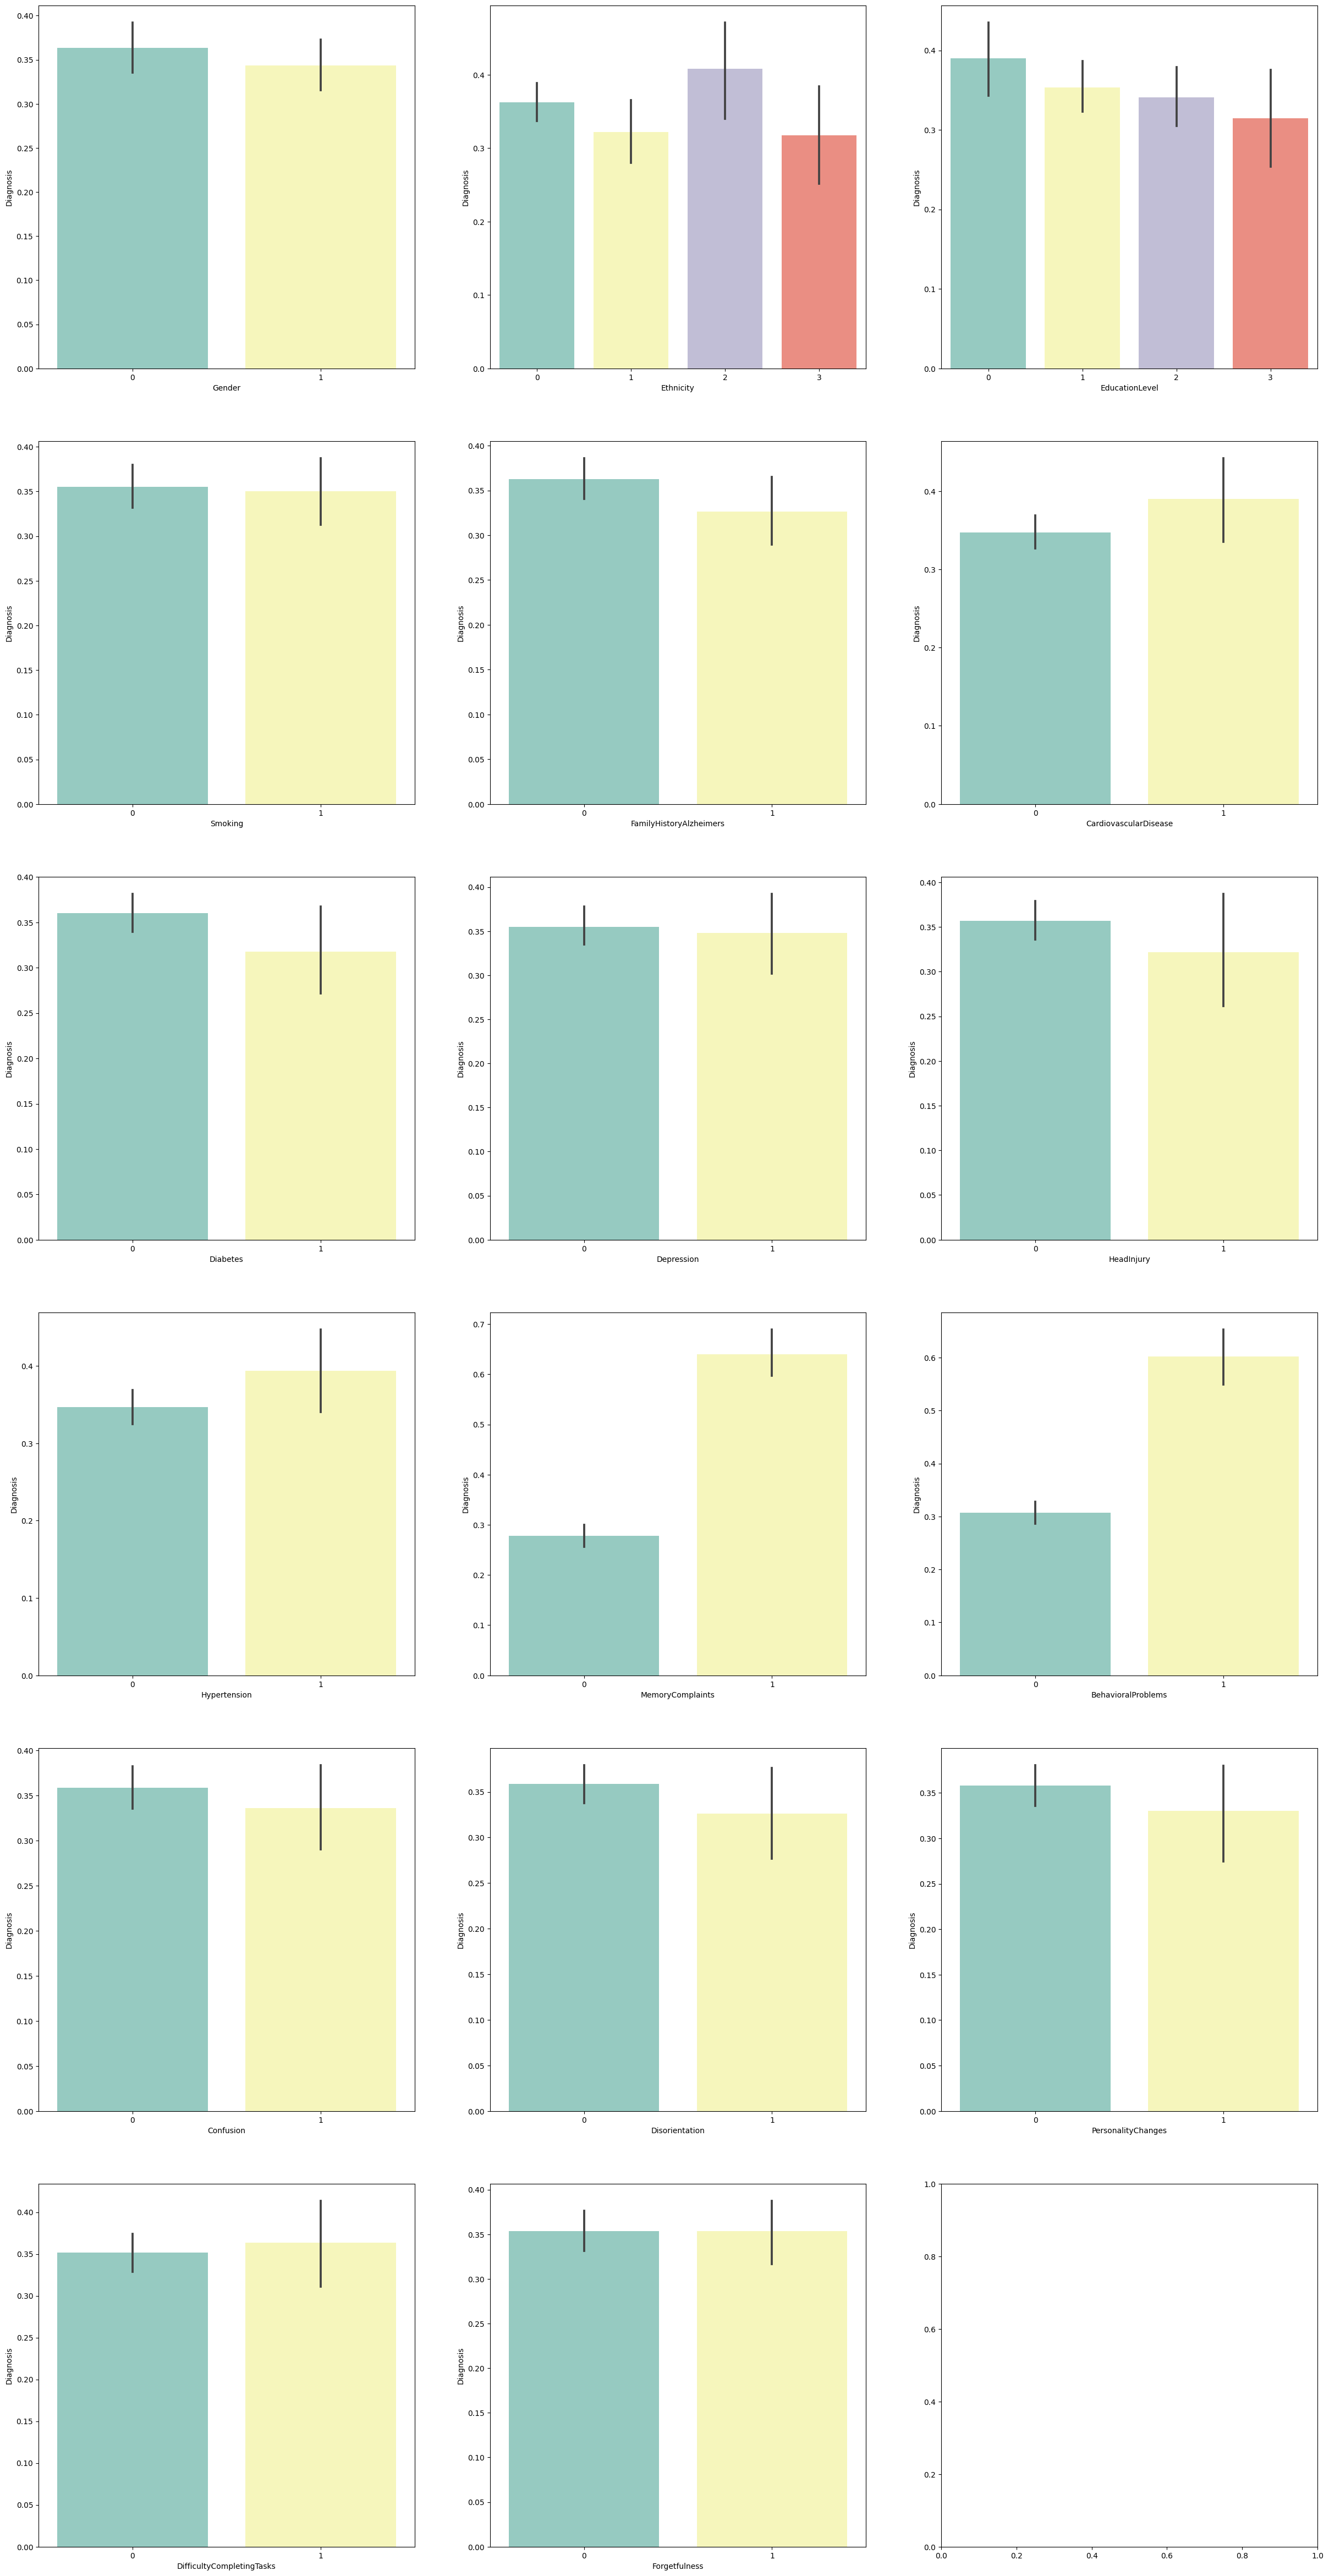

In [11]:
#Histograms
fig, ax = plt.subplots(6, 3, figsize=(30, 60))
for var, subplot in zip(discrete_features, ax.flatten()):
    sns.barplot(x=var,y= 'Diagnosis',  data=train_df, ax=subplot, palette='Set3')

Densities of MemoryComplaints and BehavioralProblems are quite different between 0-1 classes.

Let's look at the relationship between features and the target more quantitatively...

Correlation is not a good measure while measuring relations between features and target for classification problems. 

(It is good at measuring linear relations between continuous variables, but our target is discrete)

Let's check mutual information, which measures this kind of relationship well.

In [12]:
y = train_df['Diagnosis']

In [13]:
# determine the mutual information for features
#we need to fill missing values to get results from mutual_info_classif function
mutual_df = train_df[feature_list ]

mutual_info = mutual_info_classif(mutual_df.fillna(mutual_df.mean()), y, random_state=random_state)

mutual_info = pd.Series(mutual_info)
mutual_info.index = mutual_df.columns
mutual_info = pd.DataFrame(mutual_info.sort_values(ascending=False), columns = ["Numerical_Feature_MI"] )
mutual_info.style.background_gradient("cool")


,Numerical_Feature_MI
FunctionalAssessment,0.095454
ADL,0.076564
MMSE,0.066278
MemoryComplaints,0.058910
Depression,0.021590
BehavioralProblems,0.020207
AlcoholConsumption,0.017780
CholesterolHDL,0.017349
SleepQuality,0.009691
PhysicalActivity,0.007947


In [14]:
most_info_cols = mutual_info[mutual_info['Numerical_Feature_MI'] > 0.06].index.values.tolist()

Let's make one more visualization which shows a pair plot that includes only features with highest mutual information score. 

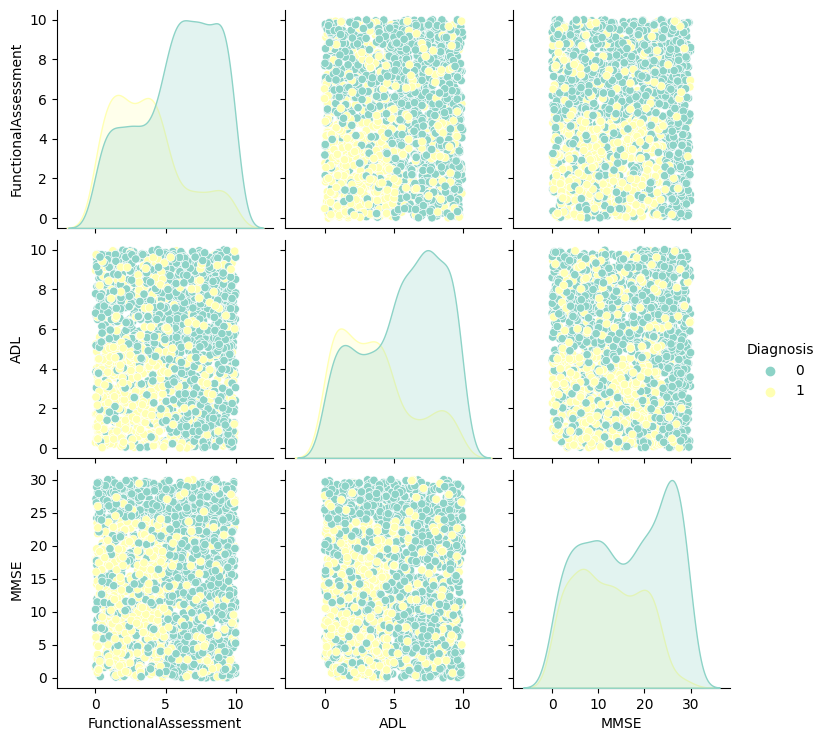

In [15]:
#pair-plot for most important features
sns.pairplot(train_df[most_info_cols + ["Diagnosis"]], hue="Diagnosis",  palette='Set3')

Lastly I will report correlations between features. Note that correlation is not a good measure for target.I will only report it for reference.

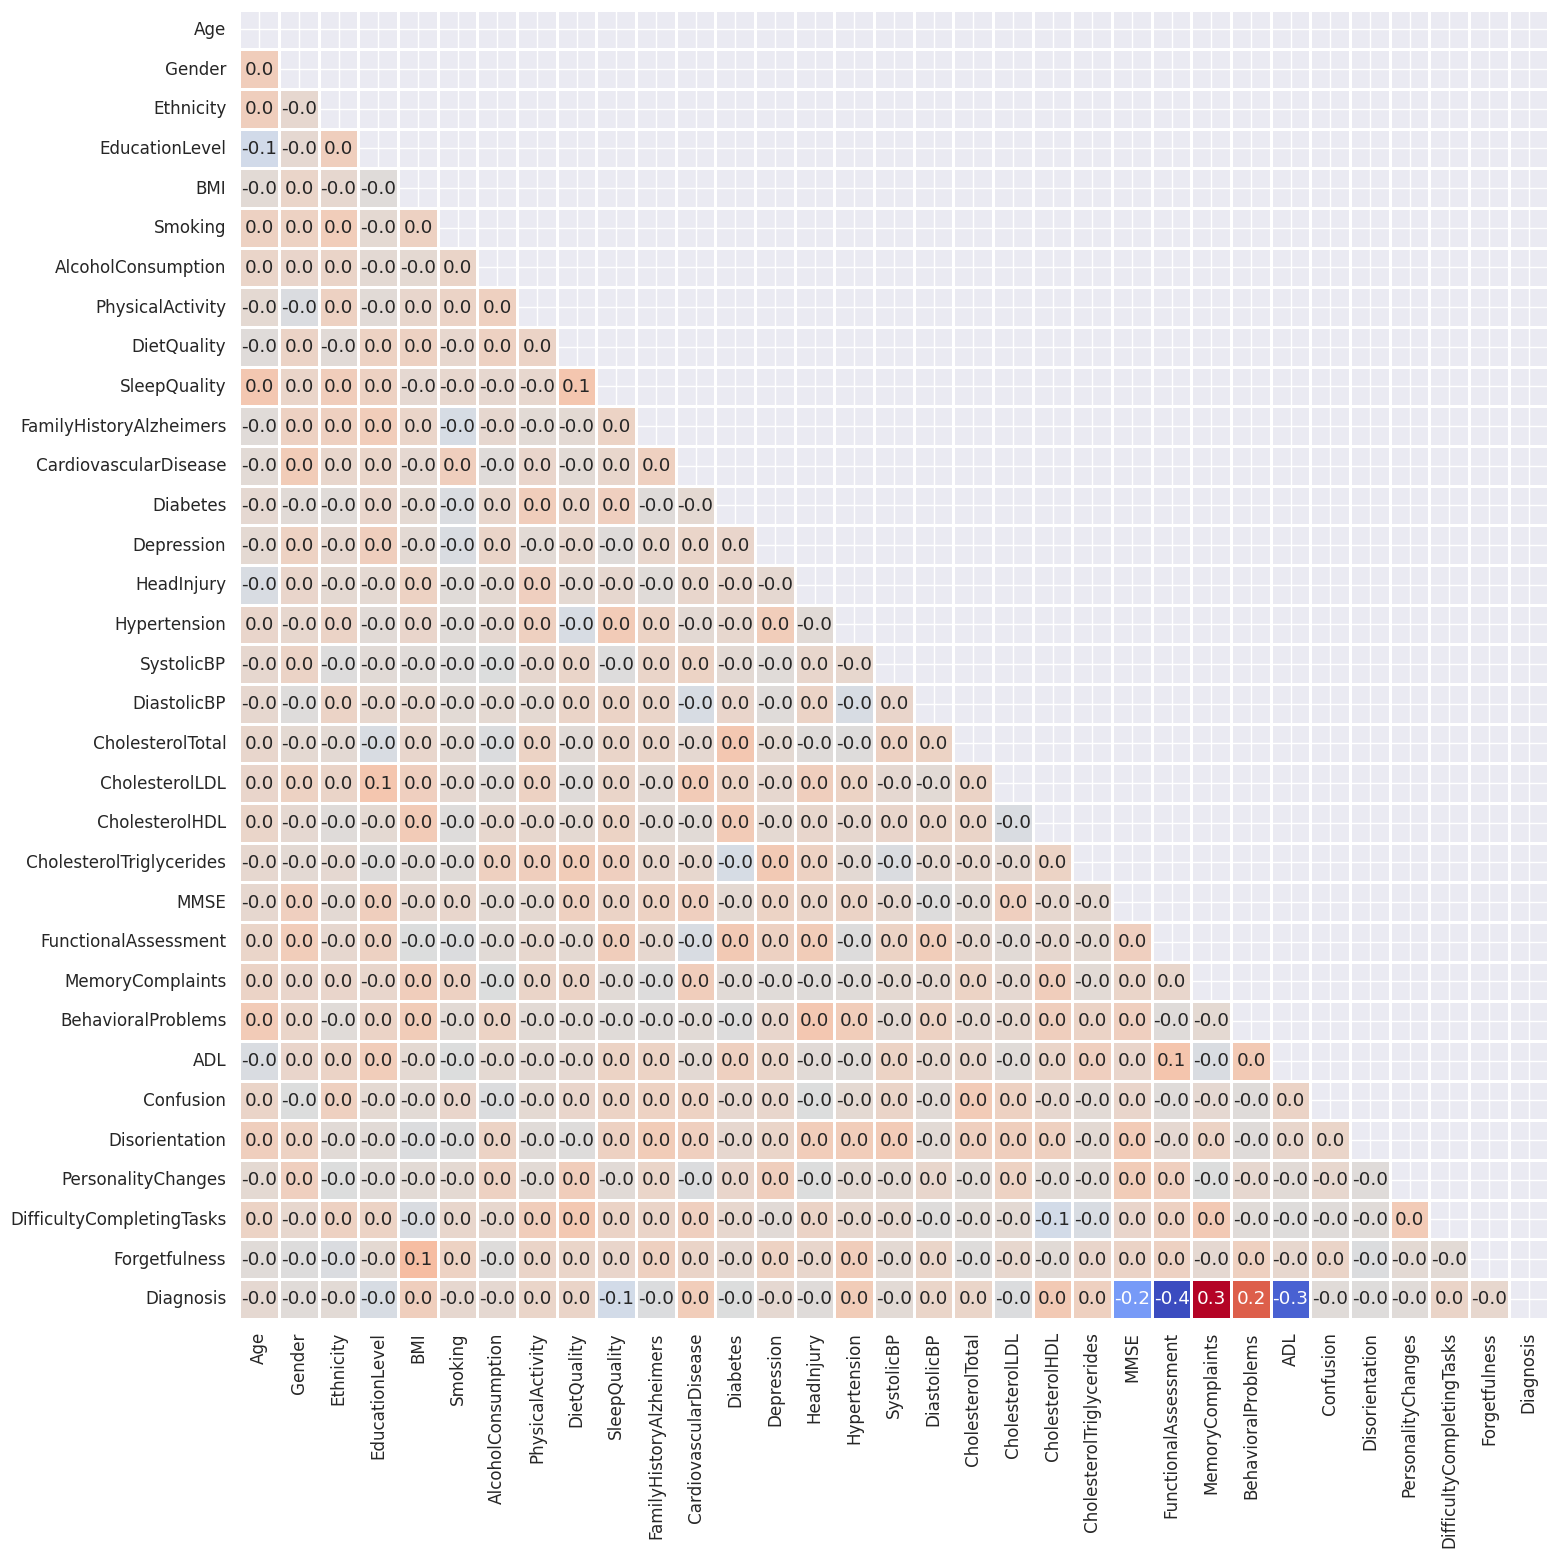

In [16]:
# Display correlations between numerical features

sns.set(font_scale=1.1)
correlation_train = train_df.corr()
mask = np.triu(correlation_train.corr())
plt.figure(figsize=(17, 17))
sns.heatmap(correlation_train,
            annot=True,
            fmt='.1f',
            cmap='coolwarm',
            square=True,
            mask=mask,
            linewidths=1,
            cbar=False);

<a id = "6"></a><br>
## Preprocessing

I will use a tree-based boosting method (XGBoost). This medhods do not require extensive preprocessing unlike linear and distance based algorithms or neural networks. So, I will not apply any preprocessing.

I only tried smote but it did not helped.

In [17]:
#SMOTE for oversampling of minority class(class 1)
#Just for reference it is not used
sm = SMOTE(random_state=random_state)

<a id = "7"></a><br>
## Splitting data to train and test sets (Perform adversarial validation)

Before moving to the modeling phase, I will create train and test splits.

Getting stable models on small datasets is often challenging. Ensuring that the training and test data distributions are similar is one of the key issues to obtain stable models.

To ensure that the distributions of the training and test data are similar, I will employ adversarial validation.

Adversarial validation is a simple technique that assesses how similar the distributions of the training and test datasets are. It involves creating a combined dataset and training a classifier to distinguish between the training and test examples based on their features. If the classifier struggles to differentiate between the two datasets, it indicates that their distributions are similar, which is crucial for building reliable models on small size datasets.

Typically, an AUC score around 0.5 indicates that the model struggles to differentiate between the train and test samples. This suggests that their distributions are similar.

To verify this, I will employ a Gaussian Naive Bayes (GaussianNB) model.


In [18]:
#seperate target
y = train_df['Diagnosis']
train_df = train_df.drop(['Diagnosis'], axis=1)


In [19]:
#create train-test split. 
X_train, X_test, y_train, y_test = train_test_split(train_df, y, 
                                                    test_size=0.2,
                                                    random_state=random_state,
                                                    shuffle=True,
                                                    stratify=y)


print(X_train.shape, X_test.shape)

(1719, 32) (430, 32)


In [20]:
adver_clf = Pipeline([
    ('scaler', StandardScaler()),
    ("GaussianNB", GaussianNB())
])

In [21]:
def adversarial_validation(X_train, X_test):
    # Label train samples as 0 and test samples as 1
    y_train = np.zeros(X_train.shape[0])
    y_test = np.ones(X_test.shape[0])
    
    # Concatenate train and test data
    X_adv = np.concatenate([X_train, X_test], axis=0)
    y_adv = np.concatenate([y_train, y_test], axis=0)
    
    # Initialize cross-validation splitter
    cv = RepeatedStratifiedKFold(n_splits=5, n_repeats=1, random_state=random_state)
    
    auc_scores = []
    for train_index, val_index in cv.split(X_adv, y_adv):
        X_adv_train, X_adv_val = X_adv[train_index], X_adv[val_index]
        y_adv_train, y_adv_val = y_adv[train_index], y_adv[val_index]
        
        # Train a classifier
        clf =  adver_clf

        clf.fit(X_adv_train, y_adv_train)
        
        # Predict probabilities for the validation set
        y_adv_pred = clf.predict_proba(X_adv_val)[:, 1]
        
        # Calculate AUC-ROC score
        auc_score = roc_auc_score(y_adv_val, y_adv_pred)
        auc_scores.append(auc_score)
    
    avg_auc_score = np.mean(auc_scores)
    
    return avg_auc_score

avg_auc_score = adversarial_validation(X_train, X_test)
print("Average AUC-ROC Score for Adversarial Validation with Cross-Validation:", avg_auc_score)

Average AUC-ROC Score for Adversarial Validation with Cross-Validation: 0.4858542242517033


With an AUC score of 0.49, it suggests that our model struggles to effectively differentiate between the train and test samples, indicating similarity in the distributions of the training and test datasets. Based on this observation, we can proceed to the modeling phase.

<a id = "8"></a><br>
# Modeling and hyperparameter tuning

%80 of the data is used for training. %20 of the data is reserved as a test set for final model evaluation. 



Although accuracy is a default metric for most classification problems, it's generally misleading for imbalanced data sets. That is why the F1 score is used as an optimization metric. 

F1 score is defined as the harmonic mean of precision and recall.

![ ]( https://www.researchgate.net/publication/367393140/figure/fig4/AS:11431281114710300@1674648981676/Confusion-matrix-Precision-Recall-Accuracy-and-F1-score.jpg)


For hyperparameter optimization OPTUNA package is used. 


Modelling phase has 3 consecutive steps:

* Step 1: Perform  hyperparameter optimization with cross validation  with using all features
* Step 2: Perform a  feature selection  based on models feature importance score with trained model in step 1
* Step 3: Repeat  hyperparameter optimization with cross validation only with selected features

<a id = "9"></a><br>
## Step 1: Train a base model with all features (XGBoost + SMOTE)

The following code block performs hyperparameter optimization with cross-validation.

It utilizes the Optuna package for hyperparameter optimization.

Cross-validation strategy: RepeatedStratifiedKFold(n_splits=5, n_repeats=1, random_state=random_state)

Note: The optimization process takes some time, so I have commented it out. 

If you want uncomment and, run it.

In [22]:
cv = RepeatedStratifiedKFold(n_splits=5, n_repeats=1, random_state=random_state)

In [23]:
#xgboost

#def objective(trial):

#    params = {
#        'n_estimators': trial.suggest_int("n_estimators", 10, 500),
#        'alpha': trial.suggest_float("alpha", 1e-8, 1.0, log=True),
#        'subsample': trial.suggest_float("subsample", 0.2, 1.0),
#        'colsample_bytree': trial.suggest_float("colsample_bytree", 0.2, 0.8),
#        'max_depth': trial.suggest_int("max_depth", 3, 12),
#        'min_child_weight': trial.suggest_int("min_child_weight", 1, 10),
#        'learning_rate': trial.suggest_float("learning_rate", 1e-4, 0.1, log=True),
#        'gamma': trial.suggest_float("gamma", 1e-8, 1.0, log=True),
#        'random_state': random_state
#    }

    # Initialize the XGBClassifier with the parameters
#    xgb_clf = XGBClassifier(**params)
  

    
#    score = cross_val_score(xgb_clf, X_train, y_train, scoring= 'f1',  cv=cv)
#    score = score.mean()
#    return score


#sampler = TPESampler(seed=random_state) # create a seed for the sampler for reproducibility
#study = optuna.create_study(direction="maximize", sampler=sampler)
#study.optimize(objective, n_trials=100)

The above code suggest best hyperparameters as following with a cross validation f1 score 0.934679915442727.

{'n_estimators': 388, 'alpha': 3.4956227371075955e-05, 'subsample': 0.9414651960372981, 'colsample_bytree': 0.7607125439856847,
'max_depth': 11, 'min_child_weight': 8, 'learning_rate': 0.016541747273769773, 'gamma': 0.07869616296834041}

I will repeat cross validation with the found hyperparameters for demostration purposes.

In [24]:
#Parameters found in tuning process by Optuna
xgb_optuna_params = {'n_estimators': 388,
                     'alpha': 3.4956227371075955e-05,
                     'subsample': 0.9414651960372981,
                     'colsample_bytree': 0.7607125439856847,
                     'max_depth': 11,
                     'min_child_weight': 8,
                     'learning_rate': 0.016541747273769773, 
                     'gamma': 0.07869616296834041}

# Model pipeline with found hyperparameters
xgb_tunned = XGBClassifier(**xgb_optuna_params, random_state=random_state)

In [25]:
# Cross-validate and report CV and test results

cv_scores = cross_val_score(xgb_tunned, X_train, y_train, cv=cv, scoring='f1')  #cross-validation
print("Mean CV Score: {:.5f}".format(np.mean(cv_scores)))

#Test score
xgb_tunned = xgb_tunned.fit(X_train, y_train)
preds_test = xgb_tunned.predict(X_test)
print("Test Score: {:.5f}".format(f1_score(y_test, preds_test)))

Mean CV Score: 0.93468
Test Score: 0.93023


Let's also visualize base model performance summary on test set and features importances from the model.

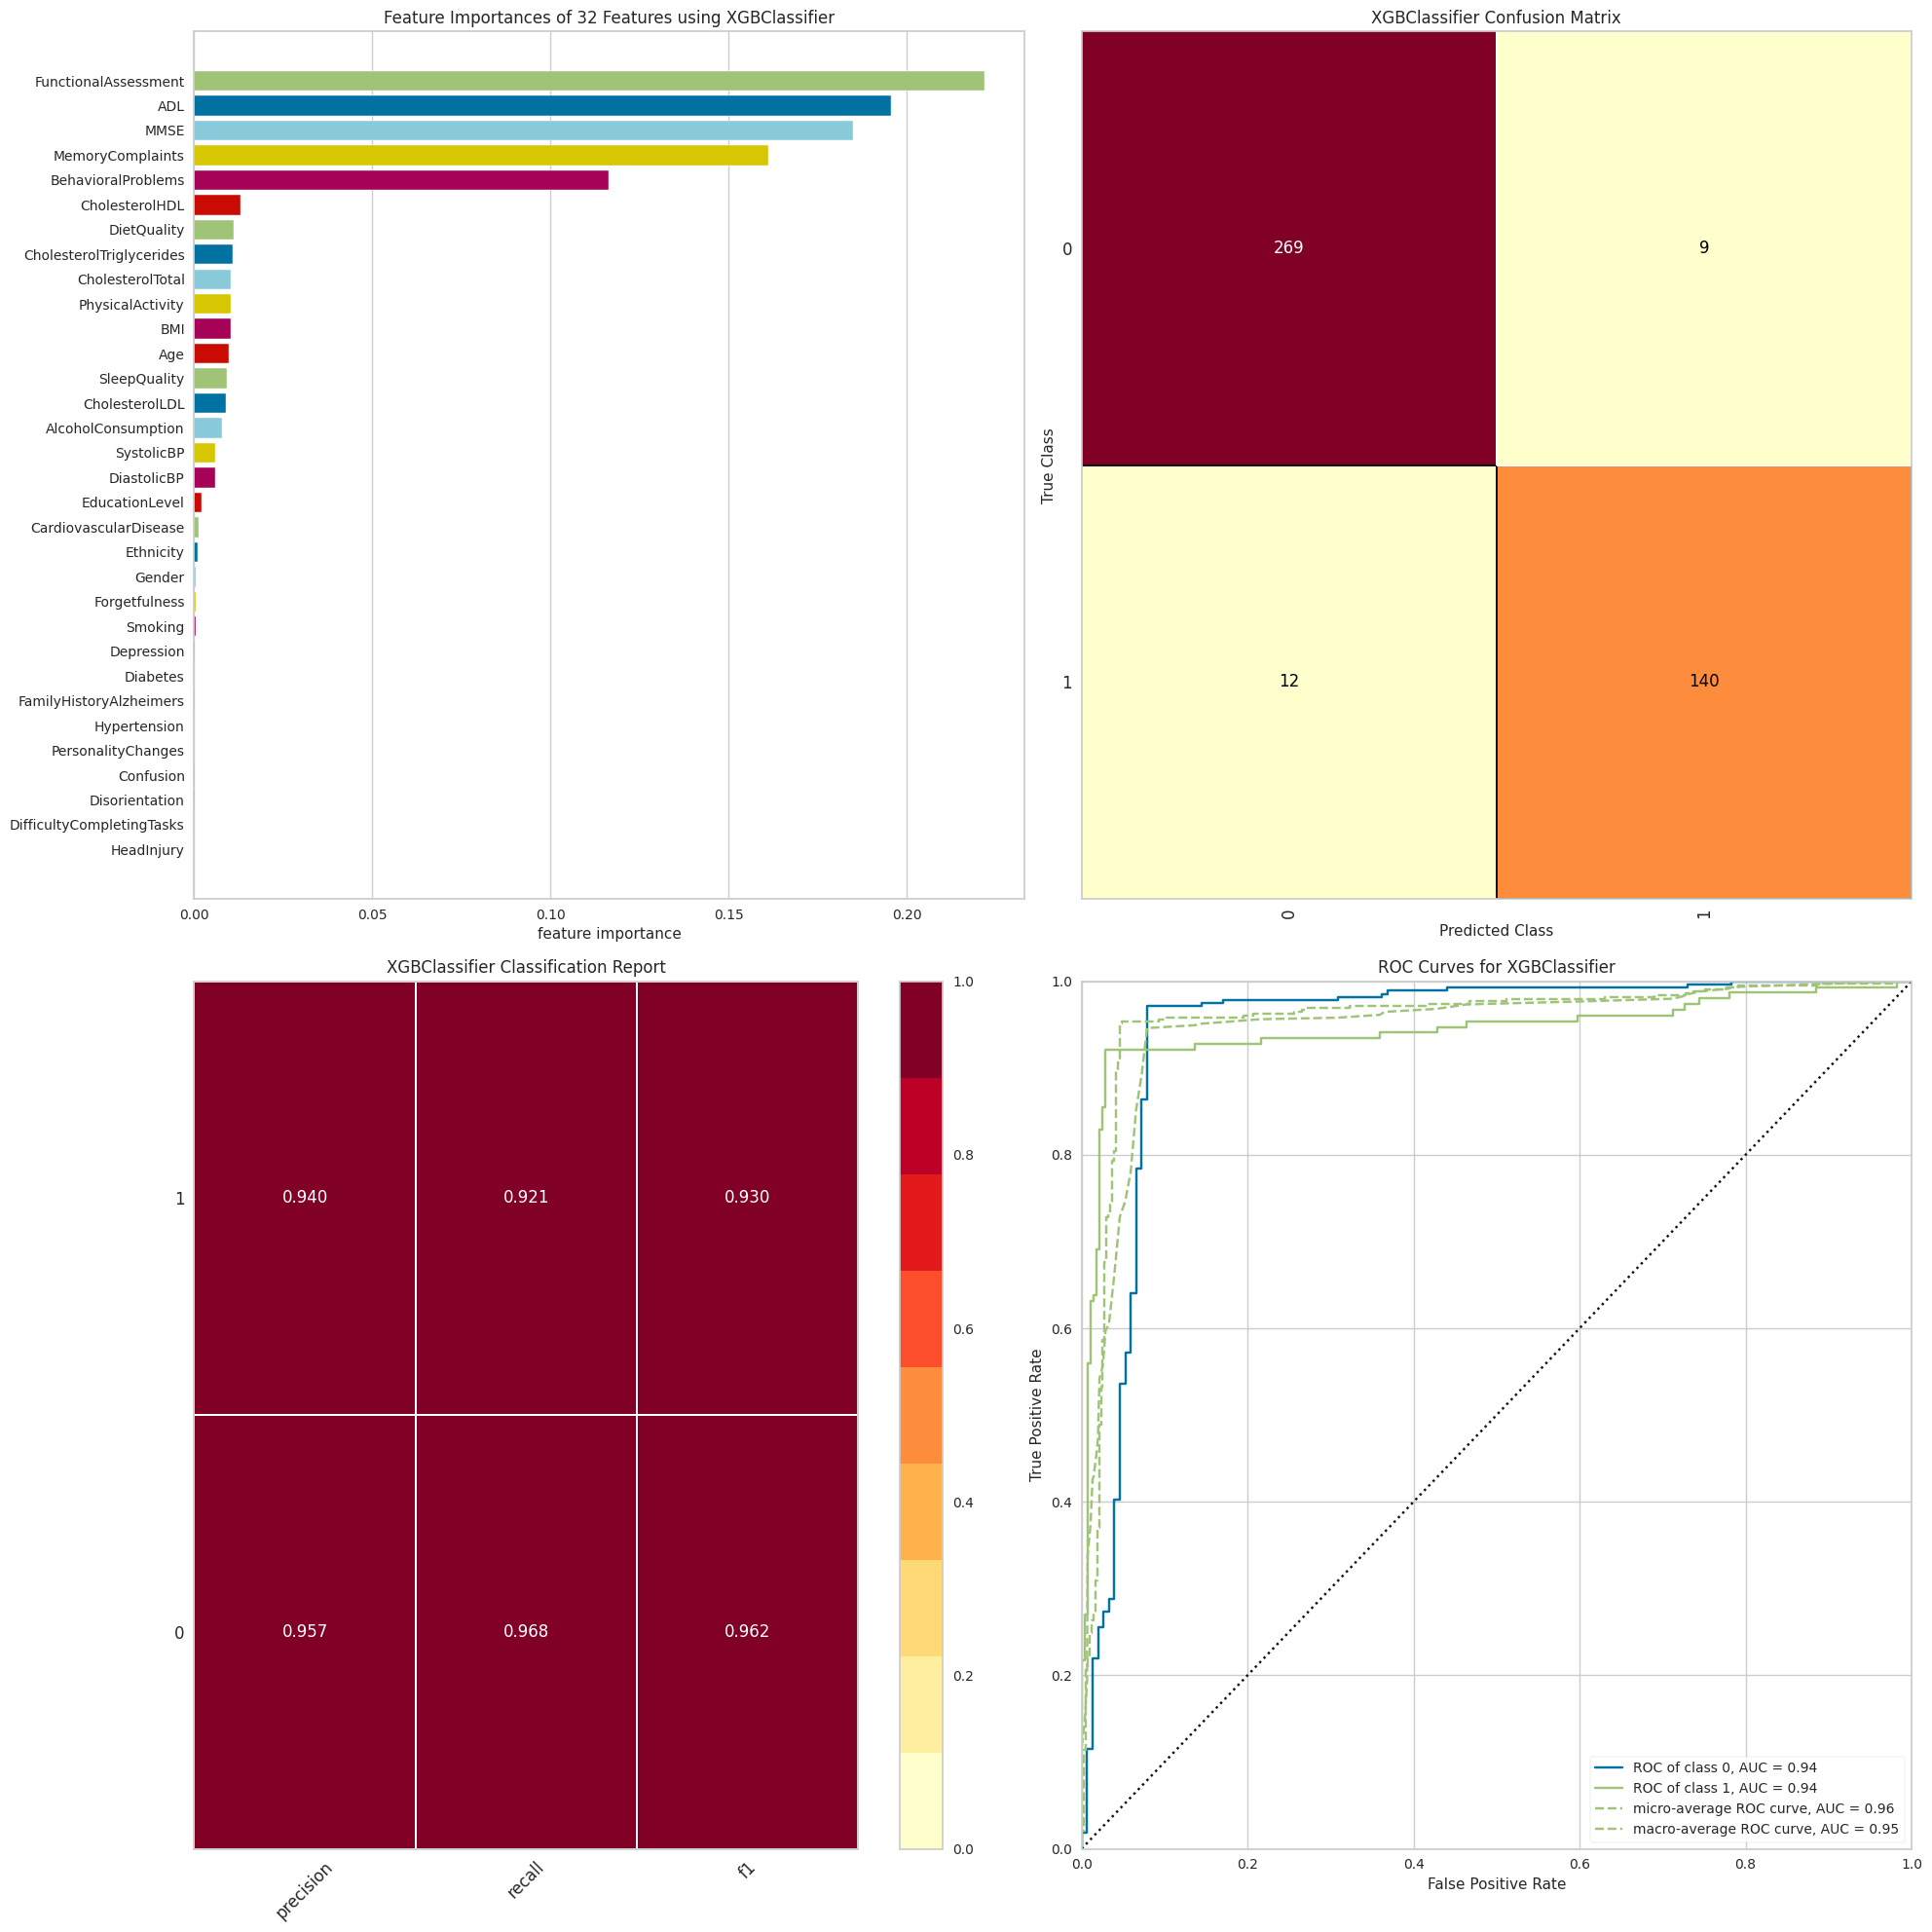

In [26]:
#yellowbrick is a good library for model evaluation visualizations
from yellowbrick.features import FeatureImportances
from yellowbrick.classifier import ConfusionMatrix, ClassificationReport, ROCAUC



fig, axes = plt.subplots(2, 2, figsize=(20, 20))

model = xgb_tunned

xgb_tunned.importance_type = 'total_gain'

visualgrid = [
    FeatureImportances(model, absolute = True, relative=False, ax=axes[0][0]),
    ConfusionMatrix(model, ax=axes[0][1]),
    ClassificationReport(model, ax=axes[1][0]),
    ROCAUC(model, ax=axes[1][1]),
]

for viz in visualgrid:
    viz.fit(X_train, y_train)
    viz.score(X_test, y_test)
    viz.finalize()

plt.show()


<a id = "10"></a><br>
## Step 2: Feature Selection Based on Model Importance Scores

The above feature importance plot shows the importance levels of features based on total_gain. Gain is defined as the improvement in accuracy brought by a feature to the branches it is on[https://xgboost.readthedocs.io/en/stable/R-package/discoverYourData.html]. 

Some of the features have a higher contribution to the decision process, while some of them have less. Less informative features are likely to result in overfitting. To assess this phenomenon, we will apply feature selection. There are many feature selection techniques. I will use the SelectFromModel() method from scikit-learn's feature selection model. This method selects features based on the model's importance scores (above importance plot). During the feature selection process, starting from the most important feature in every iteration, the next important feature is added, and cross-validation is repeated with the based model hyperparameters. The following code block demonstrates this work.

In [27]:

%%time


for i in range(1,33):


    # Create a pipeline for feature selection
    pipeline = Pipeline([
        ('selector', SelectFromModel(xgb_tunned, threshold=-np.inf, max_features= i)),
        ('classification',xgb_tunned)
    ])


    # Cross-validation scores with different number of features
    cv_scores = cross_val_score(pipeline, X_train, y_train, cv=cv, scoring='f1')  #cross-validation
    print("Number of selected features:", i)
    print("Mean CV Score: {:.4f}".format(np.mean(cv_scores)))


Number of selected features: 1
Mean CV Score: 0.5256
Number of selected features: 2
Mean CV Score: 0.6602
Number of selected features: 3
Mean CV Score: 0.7000
Number of selected features: 4
Mean CV Score: 0.8583
Number of selected features: 5
Mean CV Score: 0.9346
Number of selected features: 6
Mean CV Score: 0.9340
Number of selected features: 7
Mean CV Score: 0.9304
Number of selected features: 8
Mean CV Score: 0.9304
Number of selected features: 9
Mean CV Score: 0.9303
Number of selected features: 10
Mean CV Score: 0.9313
Number of selected features: 11
Mean CV Score: 0.9338
Number of selected features: 12
Mean CV Score: 0.9338
Number of selected features: 13
Mean CV Score: 0.9320
Number of selected features: 14
Mean CV Score: 0.9338
Number of selected features: 15
Mean CV Score: 0.9312
Number of selected features: 16
Mean CV Score: 0.9313
Number of selected features: 17
Mean CV Score: 0.9310
Number of selected features: 18
Mean CV Score: 0.9338
Number of selected features: 19
Mean 

Selecting five features yields almost the same CV score as selecting all features. Let's select 5 features and retune the XGBoost.

In [28]:
%%time


# Create a pipeline for feature selection
pipeline = Pipeline([
    ('selector', SelectFromModel(xgb_tunned, threshold=-np.inf, max_features= 5)),
    ('classification',xgb_tunned)
])

# Fit the pipeline on the training data to select features
pipeline.fit(X_train, y_train)


#Prints out selected and eleminated features
selected_features = np.array( X_train.columns)[pipeline.named_steps['selector'].get_support()]

print("Number of selected features:", len(selected_features))

print("_______________________________")

print("Selected features:", selected_features)


print("_______________________________")

print("Dropped features:", list(set(X_train.columns) - set(selected_features)))



Number of selected features: 5
_______________________________
Selected features: ['MMSE' 'FunctionalAssessment' 'MemoryComplaints' 'BehavioralProblems'
 'ADL']
_______________________________
Dropped features: ['SystolicBP', 'Ethnicity', 'EducationLevel', 'Forgetfulness', 'PersonalityChanges', 'CholesterolLDL', 'CholesterolTriglycerides', 'Hypertension', 'Confusion', 'DietQuality', 'Depression', 'AlcoholConsumption', 'CholesterolHDL', 'BMI', 'DifficultyCompletingTasks', 'Smoking', 'FamilyHistoryAlzheimers', 'Age', 'HeadInjury', 'Gender', 'Diabetes', 'SleepQuality', 'DiastolicBP', 'Disorientation', 'PhysicalActivity', 'CardiovascularDisease', 'CholesterolTotal']
CPU times: user 3.17 s, sys: 53.9 ms, total: 3.22 s
Wall time: 823 ms


In [29]:
# Reduce feature set to selected ones
X_train_selected = X_train[selected_features]
X_test_selected = X_test[selected_features]

In [30]:
# Report Cross-validation and test score with selected features

cv_scores = cross_val_score(xgb_tunned, X_train_selected, y_train, cv=cv, scoring='f1')  # cross-validation
print("Mean CV Score: {:.4f}".format(np.mean(cv_scores)))

#Test score
xgb_tunned = xgb_tunned.fit(X_train_selected, y_train)
preds_test = xgb_tunned.predict(X_test_selected)
print("Test Score: {:.4f}".format(f1_score(y_test, preds_test)))

Mean CV Score: 0.9346
Test Score: 0.9333


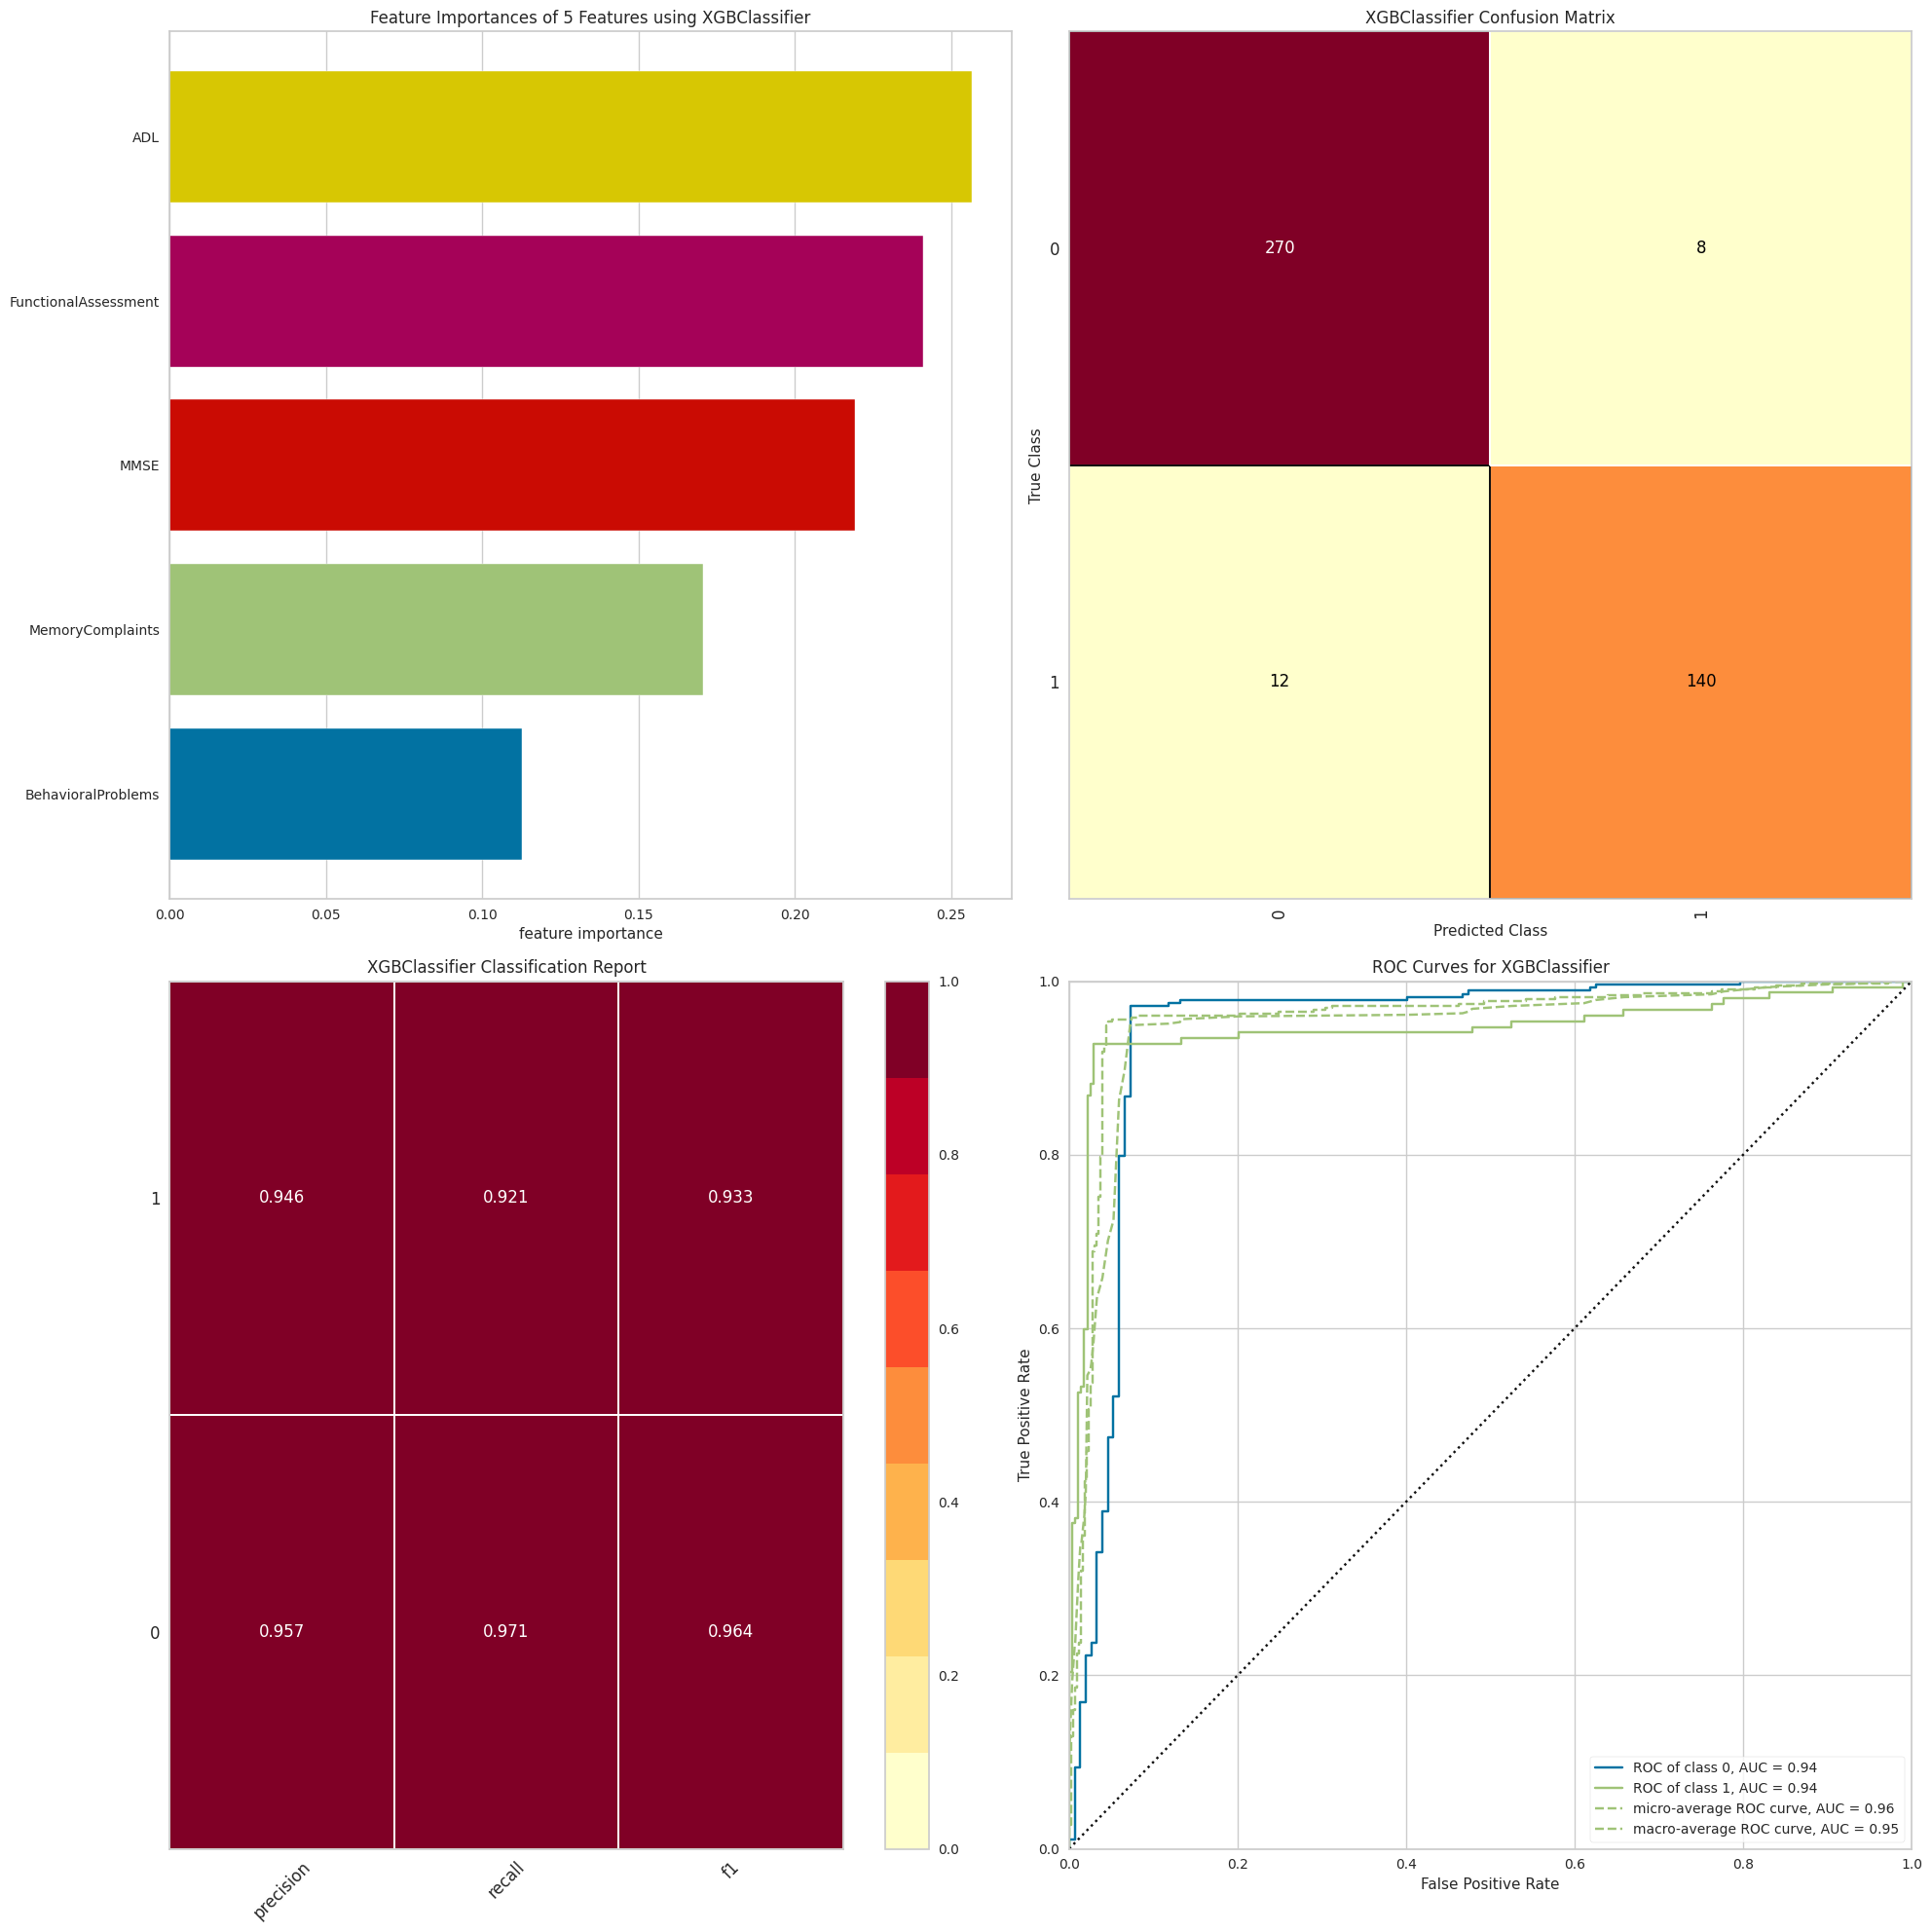

In [31]:
from yellowbrick.features import FeatureImportances
from yellowbrick.classifier import ConfusionMatrix, ClassificationReport, ROCAUC


fig, axes = plt.subplots(2, 2, figsize=(20, 20))

model = xgb_tunned

xgb_tunned.importance_type = 'total_gain'

visualgrid = [
    FeatureImportances(model, absolute = True, relative=False, ax=axes[0][0]),
    ConfusionMatrix(model, ax=axes[0][1]),
    ClassificationReport(model, ax=axes[1][0]),
    ROCAUC(model, ax=axes[1][1]),
]

for viz in visualgrid:
    viz.fit(X_train_selected, y_train)
    viz.score(X_test_selected, y_test)
    viz.finalize()

plt.show()


* Remember that we still use the base model's hyperparameters which are selected based on all features

Let's repeat hyperparameter optimization with selected features.

<a id = "11"></a><br>
## Step 3: Hyperparameter tunning with selected features

Following code block performs hyperparameter tunning only with selected features.

In [32]:
#xgboost

#def objective(trial):

#    params = {
#        'n_estimators': trial.suggest_int("n_estimators", 10, 500),
#        'alpha': trial.suggest_float("alpha", 1e-8, 1.0, log=True),
#        'subsample': trial.suggest_float("subsample", 0.2, 1.0),
#        'colsample_bytree': trial.suggest_float("colsample_bytree", 0.2, 0.8),
#        'max_depth': trial.suggest_int("max_depth", 3, 12),
#        'min_child_weight': trial.suggest_int("min_child_weight", 1, 10),
#        'learning_rate': trial.suggest_float("learning_rate", 1e-4, 0.1, log=True),
#        'gamma': trial.suggest_float("gamma", 1e-8, 1.0, log=True),
#        'random_state': random_state
#    }

    # Initialize the XGBClassifier with the parameters
#    xgb_clf = XGBClassifier(**params)
  

    
#    score = cross_val_score(xgb_clf, X_train_selected, y_train, scoring= 'f1',  cv=cv)
#    score = score.mean()
#    return score


#sampler = TPESampler(seed=random_state) # create a seed for the sampler for reproducibility
#study = optuna.create_study(direction="maximize", sampler=sampler)
#study.optimize(objective, n_trials=100) 

The above code suggest best hyperparameters as following with a cross validation f1 score 0.9418077727659157.

{'n_estimators': 500, 'alpha': 1.0812263820270055e-08, 'subsample': 0.997782211598819, 'colsample_bytree': 0.4467825164505639, 'max_depth': 12, 'min_child_weight': 8, 'learning_rate': 0.023254645894113996, 'gamma': 0.9892543136848909}

I will repeat cross validation with the found hyperparameters for demostration of findings.

In [33]:
#Parameters found in tuning process by Optuna
xgb_optuna_params = {'n_estimators': 500,
                     'alpha': 1.0812263820270055e-08,
                     'subsample': 0.997782211598819,
                     'colsample_bytree': 0.4467825164505639,
                     'max_depth': 12,
                     'min_child_weight': 8,
                     'learning_rate': 0.023254645894113996,
                     'gamma': 0.9892543136848909}

# Model pipeline with found hyperparameters
xgb_tunned = XGBClassifier(**xgb_optuna_params, random_state=random_state)

In [34]:
# F1 Cross-validation score
cv_scores = cross_val_score(xgb_tunned, X_train_selected, y_train, cv=cv, scoring='f1')  #cross-validation
print("Mean CV Score: {:.5f}".format(np.mean(cv_scores)))

#Test score
xgb_tunned = xgb_tunned.fit(X_train_selected, y_train)
preds_test = xgb_tunned.predict(X_test_selected)
print("Test Score: {:.5f}".format(f1_score(y_test, preds_test)))

Mean CV Score: 0.94181
Test Score: 0.93377


The CV score for base model with selected features was  0.93468. 

CV score is increased to  0.94181 after hyperparameter tunning with selected features (only 5 features). Also test score is increase to 0.93377.

This will be our final model. Let's also report CV scores of other metrics for this final model.

In [35]:
# Accuracy Cross-validation score

cv_scores = cross_val_score(xgb_tunned, X_train_selected, y_train, cv=cv, scoring='accuracy')  # cross-validation
print("Mean CV Score: {:.3f}".format(np.mean(cv_scores)))

#Test score
xgb_tunned = xgb_tunned.fit(X_train_selected, y_train)
preds_test = xgb_tunned.predict(X_test_selected)
print("Test Score: {:.3f}".format(accuracy_score(y_test, preds_test)))

Mean CV Score: 0.959
Test Score: 0.953


In [36]:
# AUC Cross-validation score

cv_scores = cross_val_score(xgb_tunned, X_train_selected, y_train, cv=cv, scoring='roc_auc')  #cross-validation
print("Mean CV Score: {:.3f}".format(np.mean(cv_scores)))

#Test score
xgb_tunned = xgb_tunned.fit(X_train_selected, y_train)
preds_test = xgb_tunned.predict_proba(X_test_selected)[:, 1]
print("Test Score: {:.3f}".format(roc_auc_score(y_test, preds_test)))

Mean CV Score: 0.956
Test Score: 0.943


In [37]:
# Recall Cross-validation score

cv_scores = cross_val_score(xgb_tunned, X_train_selected, y_train, cv=cv, scoring='recall')  # cross-validation
print("Mean CV Score: {:.3f}".format(np.mean(cv_scores)))

#Test score
xgb_tunned = xgb_tunned.fit(X_train_selected, y_train)
preds_test = xgb_tunned.predict(X_test_selected)
print("Test Score: {:.3f}".format(recall_score(y_test, preds_test)))

Mean CV Score: 0.931
Test Score: 0.928


Let's plot model performance summary on test set and feature importances one last time.

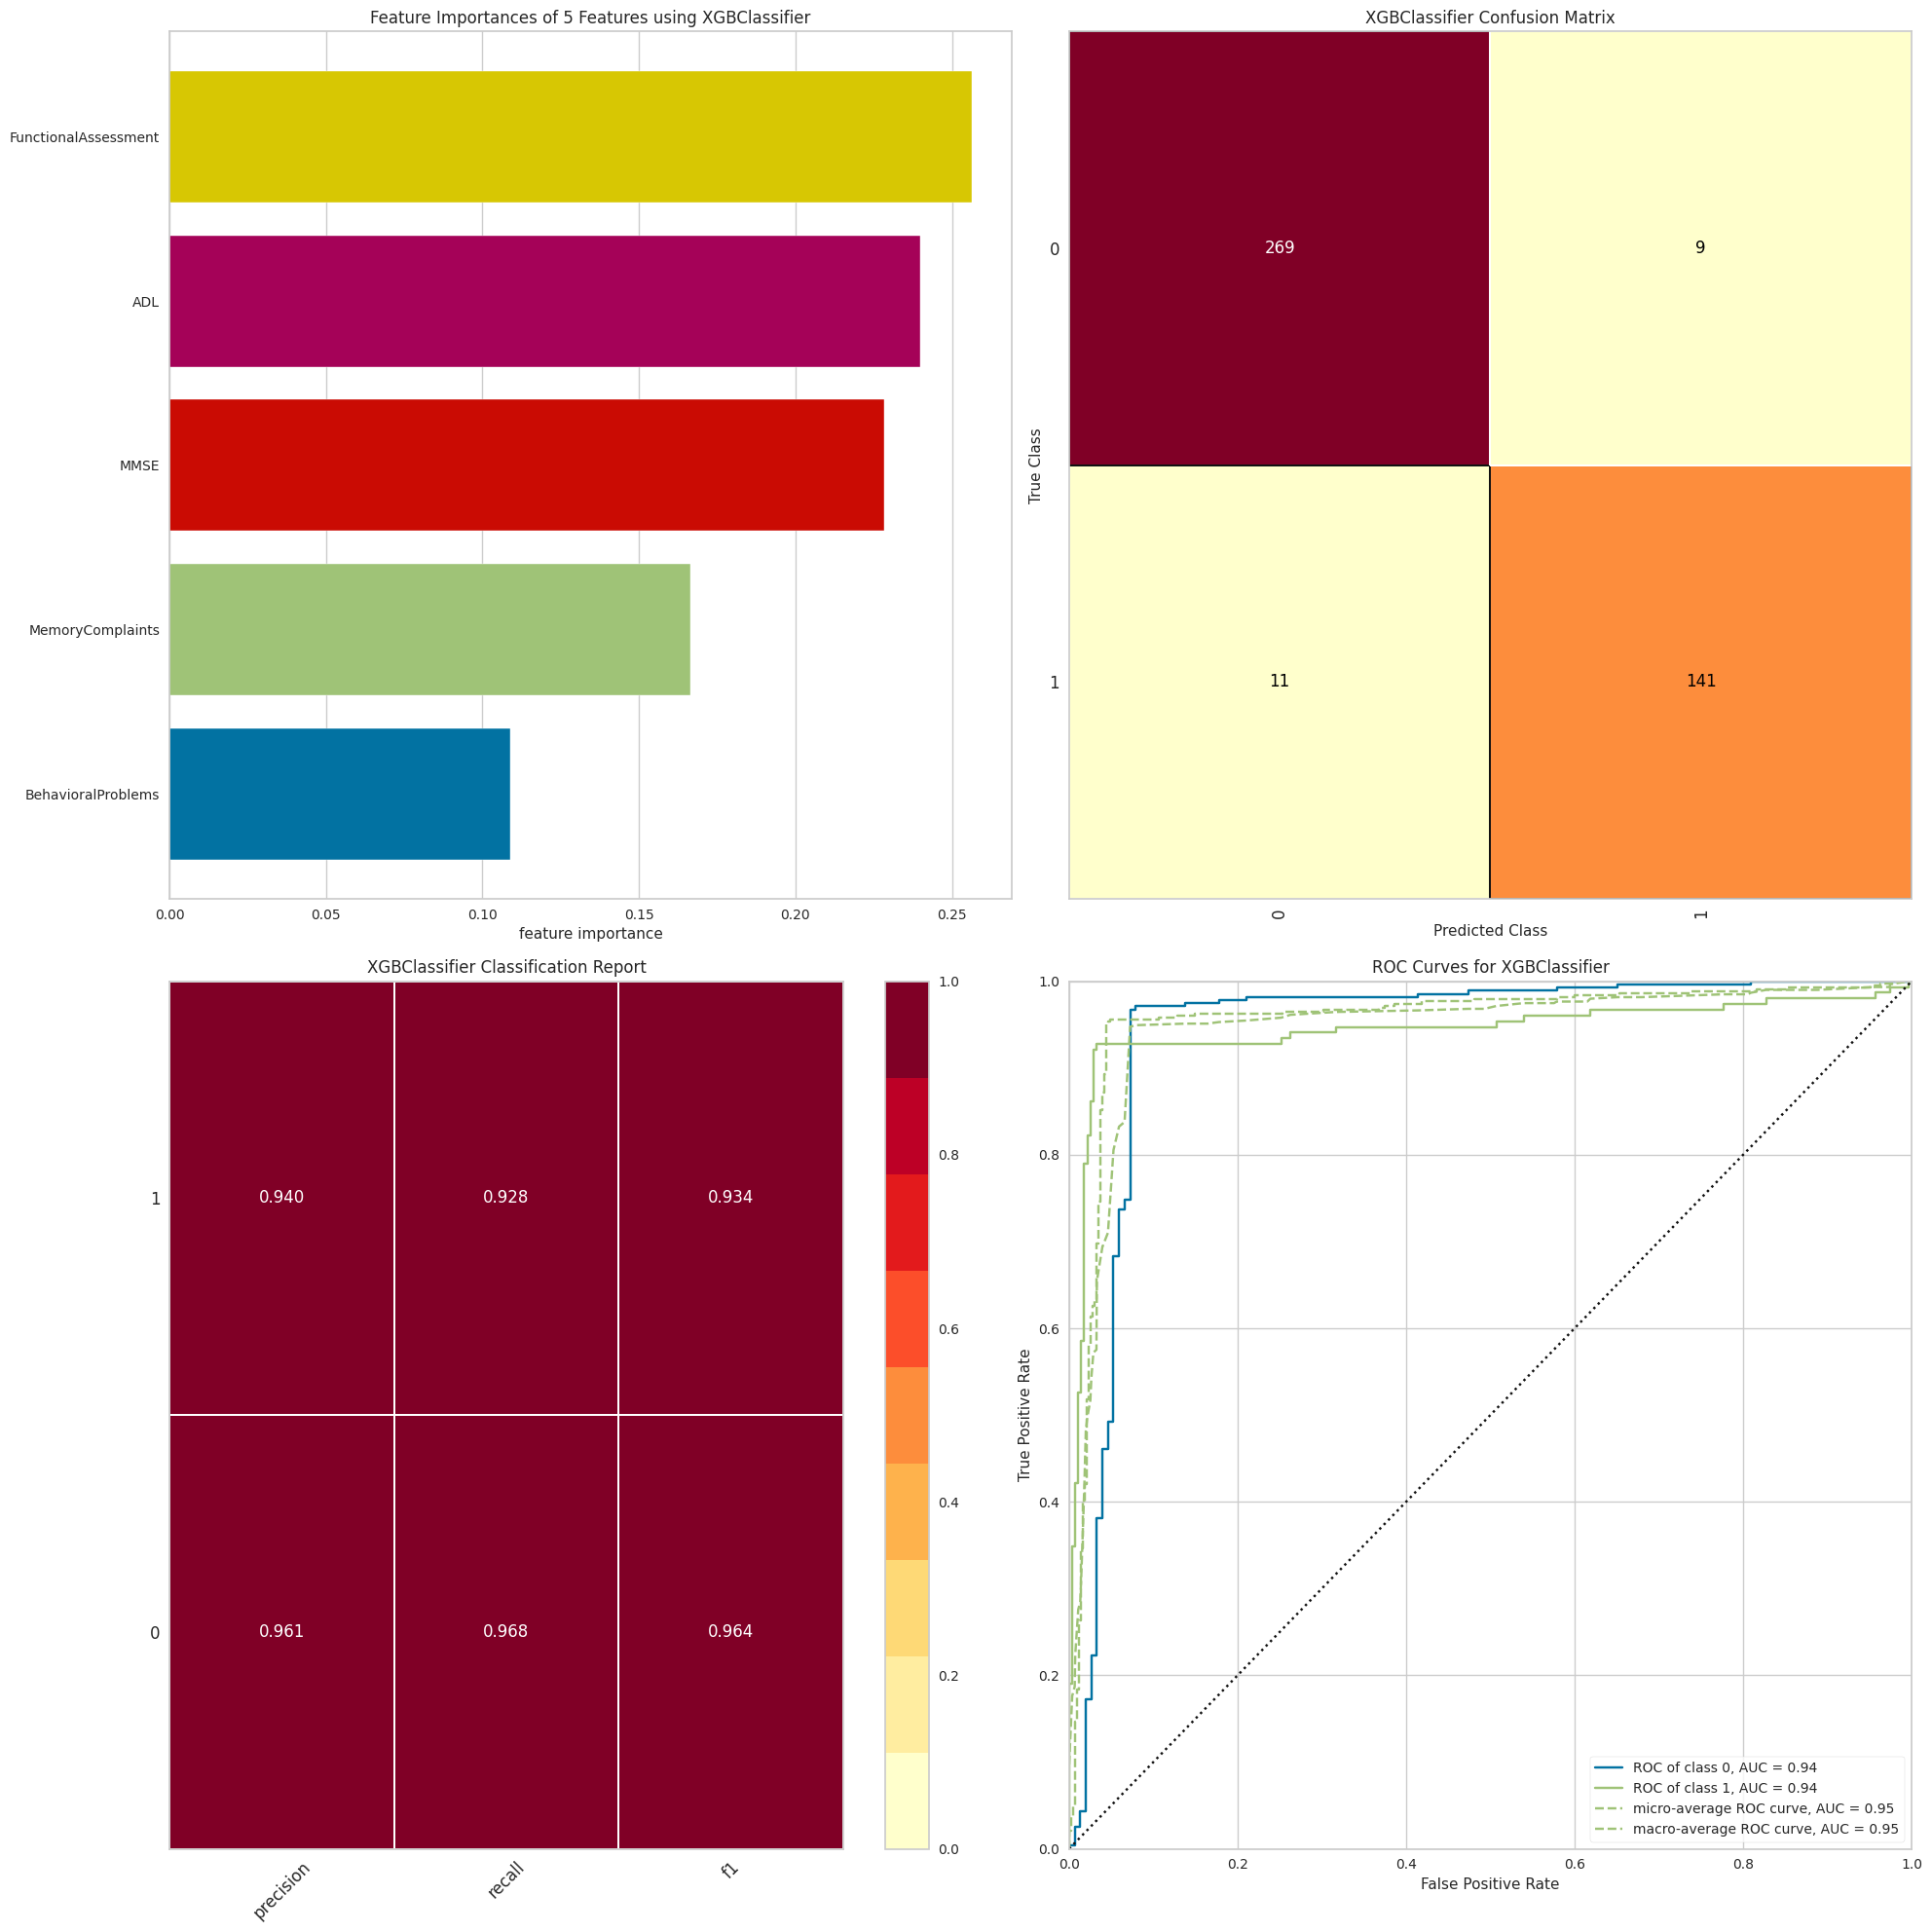

In [38]:
from yellowbrick.features import FeatureImportances
from yellowbrick.classifier import ConfusionMatrix, ClassificationReport, ROCAUC


fig, axes = plt.subplots(2, 2, figsize=(20, 20))

model = xgb_tunned

xgb_tunned.importance_type = 'total_gain'

visualgrid = [
    FeatureImportances(model, absolute = True, relative=False, ax=axes[0][0]),
    ConfusionMatrix(model, ax=axes[0][1]),
    ClassificationReport(model, ax=axes[1][0]),
    ROCAUC(model, ax=axes[1][1]),
]

for viz in visualgrid:
    viz.fit(X_train_selected, y_train)
    viz.score(X_test_selected, y_test)
    viz.finalize()

plt.show()


<a id = "12"></a><br>
## Explainable ML with SHAP

Another usefull tool for explaining machine learning models is Shapley values. Shapley values are a widely used approach from  game theory. They help Shapley-based explanations of machine learning models. 

For more information you can check: https://shap.readthedocs.io/en/latest/example_notebooks/overviews/An%20introduction%20to%20explainable%20AI%20with%20Shapley%20values.html

Lastly I want to report SHAP based feature importances.

In [39]:
#pip install shap

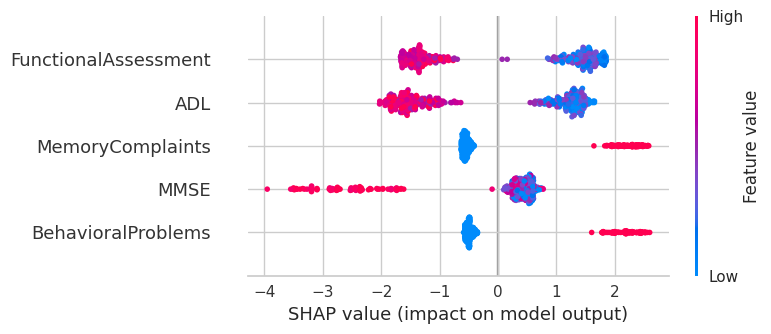

In [40]:
import shap

explainer = shap.TreeExplainer(xgb_tunned, data=X_train_selected, feature_perturbation='interventional')


shap_values = explainer.shap_values(X_test_selected)

# Summary plot of feature importance
shap.summary_plot(shap_values, X_test_selected)

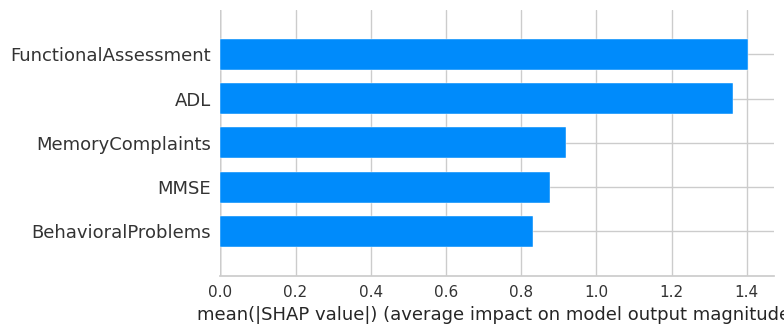

In [41]:
shap.summary_plot(shap_values, X_test_selected, plot_type = 'bar')